In [33]:
# Import data wrangling libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import datetime
import traceback
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
sns.set_style(style='ticks')

# Prediction of Permit Issue Times

## Table of Contents
* [1. Business Understanding](#1.-Business-Understanding)
	* [1.1 Problem Scope](#1.1-Problem-Scope)
    * [1.2 Use Cases](#1.2-Use-Cases)
* [2. Data Understanding](#2.-Data-Understanding)
	* [2.1 Data Sources](#2.1-Data-Sources)
	* [2.2 Column Descriptions and Additional Notes](#2.2-Column-Descriptions-and-Additional-Notes)
* [3. Data Preparation](#3.-Data-Preparation)
    * [3.1 Data Loading](#3.1-Data-Loading)
    * [3.2 Categorical Data Visualizations](#3.2-Categorical-Data-Visualizations)
    * [3.3 Numerical Data Visualizations](#3.-Numerical-Data-Visualizations)
    

## 1. Business Understanding
### 1.1 Problem Scope

A building permit is an official approval issued by the local governmental agency that allows you
or your contractor to proceed with a construction or remodeling project on your property. Those
who would like to construct, enlarge, alter, repair, move, remove, improve, convert, or demolish
a building or other structure typically apply for a building permit. Unfortunately, building permits
are often times the longest item in a project schedule; e.g. 2-3 years for a newly constructed
low-rise building). Cities review applications on a first-come, first-serve basis and must check
relevant plans to ensure they meet local building codes. I would like to predict the building
permit issue time for NYC.

### 1.2 Use Cases

1. Real estate developers may use the prediction to better optimize their project portfolio to
consider reduced project timelines, which should improve their bottom line.
2. Homeowners, especially those inexperienced in the building permitting process, will
obtain more accurate time estimates for permitting and reduce reliance on anecdotal
advice from building contractors/building department.
3. Building departments could better triage requests to potentially reduce response
turnaround time.


## 2. Data Understanding
### 2.1 Data Sources

The data was downloaded as of May 9th, 2018 from [NYC Open Data](https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a). The .csv data contains a list of permits issued for a particular day and associated data. Prior weekly and monthly reports are archived at DOB and are not available on NYC Open Data. The raw building permit data contains 60 unique columns and nearly 3.37 million rows of data. A separate .csv file provides additional detailed descriptions about the data.

### 2.2 Column Descriptions and Additional Notes


In [16]:
# Load and show data dictionary
filename = 'data/Data_Description.csv'
info = pd.read_csv(filename,encoding='latin-1')

pd.set_option('display.max_colwidth', -1)
info

,Column Name,Column Description,"Additional Notes (where applicable, include the range of possible values, units of measure, how to interpret null/zero values, whether there are specific relationships between columns, and information on column source)","Data Type (Plain Text, Number, Date)",Required
0,BOROUGH,The name of the NYC borough where the proposed work will take place.,"Expected values = Manhattan, Bronx, Brooklyn, Queens, Staten Island.",Text,Yes
1,Bin #,Building Identification Number assigned by Department of City Planning.,NaN,Number,Yes
2,House #,The house number for the building where the proposed work will take place.,"In the address, ""280 Broadway"", 280 is the house number. This number may contain a dash (-), as in ""8-15 27 Avenue"".",Text,NaN
3,Street Name,The street name for the building where the proposed work will take place.,"In the address, ""1050 Park Place"", Park Place is the street name.",Text,Yes
4,Job #,The DOB Job Application Number assigned when the applicant begins the application.,"This is the unique identifier for the application submitted to the Department. It may contain several work types, and more work types may be added as the application review and the work continues. It is a 9-digit number where the first digit indicates the borough where the building is located. \r¥ 1 = Manhattan\r¥ 2 = Bronx\r¥ 3 = Brooklyn\r¥ 4 = Queens\r¥ 5 = Staten Island",Number,Yes
5,Job doc. #,A sequential number assigned to each of the documents that make up a job application.,"Every job application should have a 01 document. Every additional document receives a number that increases by 1 (ex: 02, 03, 04)",Text,Yes
6,Job Type,"2-digit code to indicate the overall job type for the application.\r\rNote: You should also look at the Permit Type field to find out what this specific permit has been issued for. An NB job, for example, can have several different Work/Permit Types such as PL, SP, EQ, etc. And each Work/Permit Type will be issued a seperate permit.","Expected values are:\r¥ A1 = Alteration Type I, A major alteration that will change the use, egress, or occupancy of the building.\r¥ A2 = Alteration Type II, An application with multiple types of work that do not affect the use, egress, or occupancy of the building.\r¥ A3 = Alteration Type III, One type of minor work that doesn't affect the use, egress, or occupancy of the building.\r¥ NB = New Building, An application to build a new structure. ÒNBÓ cannot be selected if any existing building elements are to remainÑfor example a part of\ran old foundation, a portion of a faade that will be incorporated into the construction, etc.\r¥ DM = Demolition, An application to fully or partially demolish an existing building.\r¥ SG = Sign, An application to install or remove an outdoor sign.",Text,Yes
7,Self_Cert,Indicates whether or not the application was submitted as Professionally Certified. A Professional Engineer (PE) or Registered Architect (RA) can certify compliance with applicable laws and codes on applications filed by him/her as applicant.,Expected values are: \r¥ Y = Yes. \r¥ N = No.\r¥ blank = No information for this record.,Text,No
8,Block,Tax Block assigned to the location of the proposed work by the Department of Finance.,NaN,Text,Yes
9,Lot,Tax Lot assigned to the location of the proposed work by the Department of Finance.,NaN,Text,Yes


Relevant Acronyms may be found [here](http://www1.nyc.gov/site/buildings/about/acronym-glossary.page).

## 3. Data Preparation
### 3.1 Data Loading

First, we must import the data from .csv to a pandas dataframe, then verify that the data import was successful.

In [17]:
# Read csv by chunks to save time
filename = 'data/DOB_Permit_Issuance.csv'
tp = pd.read_csv(filename, iterator=True, chunksize=10000)
df = pd.concat(tp, ignore_index=True)

# Verify data was successfully loaded
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360294 entries, 0 to 3360293
Data columns (total 60 columns):
BOROUGH                             object
Bin #                               object
House #                             object
Street Name                         object
Job #                               int64
Job doc. #                          int64
Job Type                            object
Self_Cert                           object
Block                               object
Lot                                 object
Community Board                     object
Zip Code                            float64
Bldg Type                           float64
Residential                         object
Special District 1                  object
Special District 2                  object
Work Type                           object
Permit Status                       object
Filing Status                       object
Permit Type                         object
Permit Sequence #          

I've renamed all columns for brevity and consistency. Here we are trying to avoid:
1. extra spaces
2. capitalizations 
3. unclear column names 

In [18]:
# Create a copy of the original dataframe 
nyc = df.copy()
# Rename all of the columns
nyc.columns = ['borough',
            'bin_num',
            'house_num',
            'street_name',
            'job_num',
            'job_doc_num',
            'job_type',
            'self_certification',
            'block',
            'lot',
            'community_board',
            'zip_code',
            'bldg_type',
            'residential',
            'special_district_1',
            'special_district_2',
            'work_type',
            'permit_status',
            'filing_status',
            'permit_type',
            'permit_seq_num',
            'permit_subtype',
            'oil_gas',
            'site_fill',
            'filing_date',
            'issuance_date',
            'expiration_date',
            'job_start_date',
            'permittee_first_name',
            'permittee_last_name',
            'permittee_biz_name',
            'permittee_phone_num',
            'permittee_license_type',
            'permittee_license_num',
            'act_as_superintendent',
            'permittee_other_title',
            'hic_license',
            'site_safety_mgr_first_name',
            'site_safety_mgr_last_name',
            'site_safety_mgr_biz_name',
            'superintendent_first_last_name',
            'superintendent_biz_name',
            'owner_biz_type',
            'nonprofit',
            'owner_biz_name',
            'owner_first_name',
            'owner_last_name',
            'owner_house_num',
            'owner_house_street',
            'owner_house_city',
            'owner_house_state',
            'owner_house_zip',
            'owner_phone',
            'dob_run_date',
            'permit_si_num',
            'latitude',
            'longitude',
            'council_district',
            'census_tract',
            'nta_name']

Next, we convert object data types to more appropriate data types for reduced memory usage. The most suitable data type is inferred from looking at the dataset's head.

In [19]:
# Convert to category data type
category_data_types = ['borough', 'work_type', 'permit_type', 'job_type', 'self_certification']
int64_data_types = ['bin_num','house_num', 'block', 'lot', 'community_board', ]

def convert_datatype(lst, dtype, num=False):
    if num==False:
        for i in lst:
            nyc[i] = nyc[i].astype(dtype)
    else:
        for i in lst:
            nyc[i] = pd.to_numeric(nyc['i'], errors='coerce')

convert_datatype(category_data_types, dtype='category')

# Convert to DateTime data type
nyc['filing_date'] = pd.to_datetime(nyc['filing_date'],errors='coerce')
nyc['issuance_date'] = pd.to_datetime(nyc['issuance_date'],errors='coerce')
nyc['expiration_date'] = pd.to_datetime(nyc['expiration_date'],errors='coerce')
nyc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360294 entries, 0 to 3360293
Data columns (total 60 columns):
borough                           category
bin_num                           object
house_num                         object
street_name                       object
job_num                           int64
job_doc_num                       int64
job_type                          category
self_certification                category
block                             object
lot                               object
community_board                   object
zip_code                          float64
bldg_type                         float64
residential                       object
special_district_1                object
special_district_2                object
work_type                         category
permit_status                     object
filing_status                     object
permit_type                       category
permit_seq_num                    int64
permit_subtype   

We create a new column called "issue_time" to serve as a continuous dependent variable in upcoming exploratory data analyses (EDA) or machine learning tasks. The issue time (days) is the difference between the issuance date and the filing date of the building permit. Categorical dependent variables may be created at the EDA stage as we better understand the limitations of the data.

In [20]:
# Create continuous numerical dependent variable 
pd.set_option('display.max_columns', None)
nyc['issue_time'] = (nyc['issuance_date'] - nyc['filing_date']).dt.days


Let's now decide if we need to impute, delete or wait on making modifications to the data. First, we need to figure out how many NaNs are there in the dataset.

In [21]:
# Determine the nulls for each column
nyc.isnull().sum()

borough                           0      
bin_num                           0      
house_num                         4      
street_name                       4      
job_num                           0      
job_doc_num                       0      
job_type                          0      
self_certification                1272696
block                             499    
lot                               508    
community_board                   4684   
zip_code                          1327   
bldg_type                         54472  
residential                       2075083
special_district_1                2998960
special_district_2                3290759
work_type                         587802 
permit_status                     10507  
filing_status                     0      
permit_type                       1      
permit_seq_num                    0      
permit_subtype                    1339058
oil_gas                           3322850
site_fill                         

The columns that contain a majority of the NaNs were optional based on the observations from thhe data understanding phase, such as the "site_safety_mgr_first_name". These records are left as NaN for now.

Some (very few) permit status's are considered "revoked." We will remove these permits because they will never be issued.

In [22]:
# Remove revoked permits
(nyc.permit_status == "REVOKED").sum()
nyc = nyc.loc[nyc['permit_status']!='REVOKED']
nyc[['permit_status']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3360289 entries, 0 to 3360293
Data columns (total 1 columns):
permit_status    object
dtypes: object(1)
memory usage: 51.3+ MB


Luckily, the dependent variable, issue time, has very few NaNs (0.06%). I have decided to remove these for now because I am primarily interested in predicting building permit times of issued permits.

Remove obvious irrelevant features, e.g. phone numbers, etc.

In [23]:
nyc = nyc.drop(['bin_num', 'house_num', 'street_name', 'job_num', 'job_doc_num', 'special_district_1', 'special_district_2', 'permit_seq_num', 'oil_gas', 'site_fill', 'permittee_first_name', 'permittee_last_name', 'permittee_biz_name', 'permittee_phone_num', 'permittee_license_num', 'act_as_superintendent', 'permittee_other_title', 'hic_license', 'site_safety_mgr_first_name', 'site_safety_mgr_last_name', 'site_safety_mgr_biz_name', 'superintendent_first_last_name', 'superintendent_biz_name', 'owner_biz_type', 'owner_first_name', 'owner_last_name', 'owner_house_num', 'owner_house_street', 'owner_house_city', 'owner_house_state', 'owner_house_zip', 'owner_phone', 'dob_run_date','self_certification', 'block', 'lot','community_board', 'zip_code', 'residential', 'owner_biz_name', 'permit_si_num'], axis = 1)

In [54]:
# View clean dataset
pd.set_option('display.max_columns', None)
nyc.head()

,borough,job_type,bldg_type,work_type,permit_status,filing_status,permit_type,permit_subtype,filing_date,issuance_date,expiration_date,job_start_date,permittee_license_type,nonprofit,latitude,longitude,council_district,census_tract,nta_name,issue_time
0,BROOKLYN,A1,2.0,PL,ISSUED,RENEWAL,PL,NaN,2009-01-23,2009-01-23,01/23/2010 12:00:00 AM,01/16/2008 12:00:00 AM,MP,NaN,40.685414,-73.975096,35.0,35.0,Fort Greene,0.0
1,MANHATTAN,A3,2.0,EQ,IN PROCESS,INITIAL,EQ,SF,2011-03-17,NaT,NaN,03/17/2011 12:00:00 AM,NaN,N,40.751531,-73.984105,4.0,84.0,Midtown-Midtown South,NaN
2,MANHATTAN,A2,2.0,OT,IN PROCESS,INITIAL,EW,OT,2003-11-21,NaT,NaN,11/21/2003 12:00:00 AM,NaN,N,40.818629,-73.946786,9.0,22102.0,Central Harlem North-Polo Grounds,NaN
3,MANHATTAN,A2,2.0,SP,IN PROCESS,INITIAL,EW,SP,2011-09-07,NaT,NaN,09/07/2011 12:00:00 AM,NaN,N,40.760549,-73.976421,4.0,104.0,Midtown-Midtown South,NaN
4,BROOKLYN,A2,1.0,OT,IN PROCESS,INITIAL,EW,OT,2002-10-07,NaT,NaN,10/07/2002 12:00:00 AM,NaN,N,40.634515,-74.020573,43.0,126.0,Bay Ridge,NaN


### 3.2 Categorical Data Visualizations
I initially explore the data for any potential outliers and trends to better prepare for the EDA phase. 

- **What are the most frequent permit types submitted and are there outliers?** From the subplots below, electrical work is the most popular permit type. Permit types for DM (Demolition and Removal) and FO (Foundations) may also be considered outliers. They are considered outliers because their share of the data is much smaller compared to the other categories in their feature.


- **Are most permits issued?** Yes, it seems like the vast majority of permits are issued. Permit statuses that are in-process and re-issued may be considered outliers.


- **Are most submittals first-time or renewals?** It seems like initial submittals are more than two times than higher than renewals.


- **How do the boroughs rank in building permit frequency?** 1) Manhattan, 2) Brooklyn, 3) Queens, 4) Bronx, and 5) Staten Island


/Users/tsed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys
/Users/tsed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
/Users/tsed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
/Users/tsed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


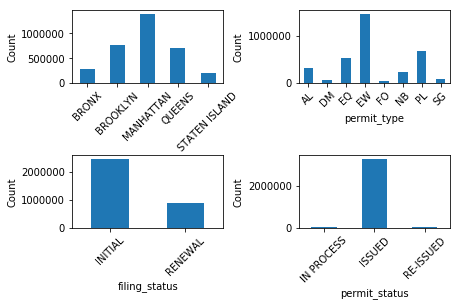

In [25]:
# Visualize potentially important features to explore in future data explorations

# Create 2X2 sub plots
fig, axes = plt.subplots(nrows=2, ncols=2)

# Grouping and aggregations of several features
df1 = nyc.groupby('borough',as_index=True)['borough'].agg({'count':'count'})
df2 = nyc.groupby('permit_type',as_index=True)['permit_type'].agg({'count':'count'})
df3 = nyc.groupby('filing_status',as_index=True)['filing_status'].agg({'count':'count'})
df4 = nyc.groupby('permit_status',as_index=True)['permit_status'].agg({'count':'count'})

# Plot bar graphs
ax1 = df1.plot(ax=axes[0,0], kind='bar', rot=45, legend=False)
ax2 = df2.plot(ax=axes[0,1], kind='bar', rot=45, legend=False)
ax3 = df3.plot(ax=axes[1,0], kind='bar', rot=45, legend=False)
ax4 = df4.plot(ax=axes[1,1], kind='bar', rot=45, legend=False)
ax1.set_ylabel("Count")
ax2.set_ylabel("Count")
ax3.set_ylabel("Count")
ax4.set_ylabel("Count")

plt.subplots_adjust(top=None, bottom=None, left=None, right=1, hspace=1,
                    wspace=0.5)
plt.show()

### 3.3 Numerical Data Visualizations
Now we turn our attention to some important numerical features to initially explore the questions. Below I have plotted an overlapping time series to inspect any anomalies in the frequency of building permits over the years

- **Are most filed permits issued as well?** The issuance and filing are practically following the same trend showing that almost all of the building permits that are filed are also issued.


- **How has building permits issuance frequency changed over time?** From visual inspection I notice that since the 2008 U.S. recession, building permits have been relatively chaotic in their issuance and filing, but generally on a slow upwards trend. This trend makes sense because the building industry is a notoriously cyclical industry that seems to have a strong correlation with the U.S. economy. 


/Users/tsed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
/Users/tsed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


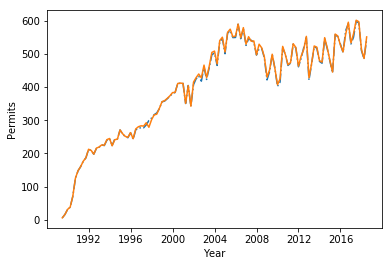

In [26]:
# Visualize Permit Issue Date 
issue_date = nyc.groupby('issuance_date',as_index=True)['issuance_date'].agg({'count':'count'})
filing_date = nyc.groupby('filing_date',as_index=True)['filing_date'].agg({'count':'count'})

issue_date.index = pd.to_datetime(issue_date.index)
issue_date = issue_date.resample('Q').mean()

filing_date.index = pd.to_datetime(filing_date.index)
filing_date = filing_date.resample('Q').mean()

plt.plot(issue_date, '-.')
plt.plot(filing_date)
plt.ylabel('Permits')
plt.xlabel('Year')
plt.show()

#http://benalexkeen.com/resampling-time-series-data-with-pandas/

When I initially explored the issue time feature, I found that a majority of the permits were issued on the same-day, and that the data was highly skewed to the right. I decided to omit same-day issue times because I do not believe there is much value in knowing if they could get a permit the same-day compared to permits that take months if not years.


Below I have plotted a histogram of issue times in the past five years into four time range groups. Outliers may be due to measurement/input error, data corruption, or perhaps actually represent legitimate behavior. I used Tukey fences as a simple way to determine outliers, i.e. a record is considered an outlier if it is 1.5 times the interquartile range. The dependent variable, issue time (days), is heavily right skewed based on its histogram. From the histogram, I observed negative values for the issue time, which I subsequently removed from the analysis because of suspected input error. On the other hand, outliers are present for permits requiring multiple years to be issued, and I suspect these represent legitimate records. For example, new buildings, especially high-rise and skyscrapers, typically require a much longer time to obtain a building permit compared to an average project. From the data, I notice that in the last five years some of these projects needed up to four years to obtain a building permit. One approach is to simply trim the bottom 1-5% of data, but there may be value in understanding the factors that lead to multi-year building permit issue times. However, it would be a good idea to trim permits with less than a month to issue. Permits with issue times less than a month are primarily from “quick-fix” projects, e.g. minor electrical work, which generally are more predictable and probably don’t provide much value to the client if included in this study.

Based on the visualization, I asked and answered the following question:

- **Is there enough data to continue EDA after filtering the data?** Yes, there seems to be thousands of records still available even after filtering


- **Is the data still skewed to the right and why?** Yes, and this is likely because buildings that require longer issuance times generally require a more careful inspection of plan sets.


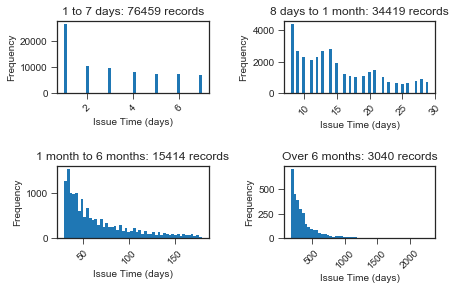

In [50]:
# Create 2X2 sub plots
fig, axes = plt.subplots(nrows=2, ncols=2)

# Filter for most recent data
recent_nyc = nyc[nyc['filing_date'] >= datetime.date(2012,1,1)]

# Visualize Permit Issue Date 
same_day = recent_nyc[(recent_nyc['issue_time']==0)]

df5 = recent_nyc[(recent_nyc['issue_time']>=1) & (recent_nyc['issue_time']<8)]
df6 = recent_nyc[(recent_nyc['issue_time']>=8) & (recent_nyc['issue_time']<30)]
df7 = recent_nyc[(recent_nyc['issue_time']>=30) & (recent_nyc['issue_time']<180)]
df8 = recent_nyc[recent_nyc['issue_time']>=180]
    
# Plot bar graphs
ax5 = df5.issue_time.plot(ax=axes[0,0], kind='hist', bins=50, rot=45, legend=False)
ax6 = df6.issue_time.plot(ax=axes[0,1], kind='hist', bins=50, rot=45, legend=False)
ax7 = df7.issue_time.plot(ax=axes[1,0], kind='hist', bins=50, rot=45, legend=False)
ax8 = df8.issue_time.plot(ax=axes[1,1], kind='hist', bins=50, rot=45, legend=False)

ax5.set_xlabel("Issue Time (days)")
ax6.set_xlabel("Issue Time (days)")
ax7.set_xlabel("Issue Time (days)")
ax8.set_xlabel("Issue Time (days)")

ax5.set_title("1 to 7 days: " + str(df5['issue_time'].count()) + ' records')
ax6.set_title("8 days to 1 month: " + str(df6['issue_time'].count()) + ' records')
ax7.set_title("1 month to 6 months: " + str(df7['issue_time'].count()) + ' records')
ax8.set_title("Over 6 months: " + str(df8['issue_time'].count()) + ' records')

plt.subplots_adjust(top=None, bottom=None, left=None, right=1, hspace=1,
                    wspace=0.5)
plt.show()


I decided that it was acceptable to remove records where the proportion of nulls to total records is extremely small, e.g. the nulls in the latitude feature were less than 1% of the total number of records. For other features, I’ve decided to use a decision tree classifier to automatically categorize the empty records into their own category and calculate their log likelihoods, which avoids data imputation, data removal, and throws no errors using machine learning algorithms. This decision tree approach will be done at the EDA stage.

In [51]:
recent_nyc.isnull().sum()

borough                   0     
job_type                  0     
bldg_type                 53    
work_type                 157446
permit_status             2069  
filing_status             0     
permit_type               0     
permit_subtype            393040
filing_date               0     
issuance_date             7895  
expiration_date           5636  
job_start_date            5     
permittee_license_type    5406  
nonprofit                 4697  
latitude                  4503  
longitude                 4503  
council_district          4503  
census_tract              4503  
nta_name                  4503  
issue_time                7895  
dtype: int64

In [52]:
recent_nyc = recent_nyc.dropna(subset=['issue_time','latitude', 'longitude'])

In [53]:
recent_nyc.isnull().sum()

borough                   0     
job_type                  0     
bldg_type                 52    
work_type                 153929
permit_status             2051  
filing_status             0     
permit_type               0     
permit_subtype            386841
filing_date               0     
issuance_date             0     
expiration_date           0     
job_start_date            5     
permittee_license_type    0     
nonprofit                 4648  
latitude                  0     
longitude                 0     
council_district          0     
census_tract              0     
nta_name                  0     
issue_time                0     
dtype: int64

In [31]:
# Store dataframe for exploratory data analysis (EDA)
%store recent_nyc

Stored 'recent_nyc' (DataFrame)
